In [26]:
import torch.optim as optim
from torch import nn
from torch.utils import data
import torch
import torchvision
import torchvision.transforms as transforms
import math
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import pickle
from torchsummary import summary
from skimage import io, transform

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
#All the parameters
epoch = 15
lr = 0.001
weight_decay = 0.0001
gamma = 0.99
resnet_type = {
    18: torchvision.models.resnet18,
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50
}

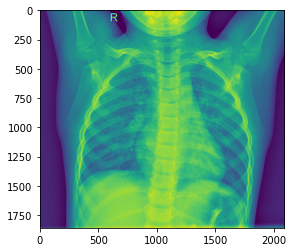

Image mode RGB
['NORMAL', 'PNEUMONIA']


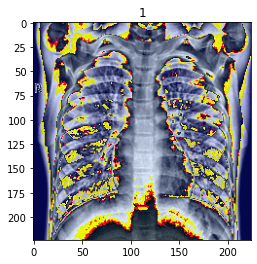

Image mode <built-in method mode of Tensor object at 0x7f686335a830>


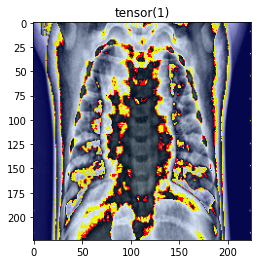

Image mode <built-in method mode of Tensor object at 0x7f68619c2e90>


In [29]:
trainTransform = transforms.Compose([
    #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomCrop(32, padding=4),
    transforms.Resize((224, 224)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
    ])

testTransform = transforms.Compose([ 
    transforms.Resize((224, 224)),
    transforms.Grayscale(3),   
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))])


#TO DO
#Add data loading

plt.imshow(io.imread("/content/drive/MyDrive/ASUB/chest_xray/train/NORMAL/IM-0115-0001.jpeg"))
plt.show()


im = Image.open("/content/drive/MyDrive/ASUB/chest_xray/train/NORMAL/IM-0115-0001.jpeg").convert('RGB')
print(f"Image mode {im.mode}")

trainSet = torchvision.datasets.ImageFolder("/content/drive/MyDrive/ASUB/chest_xray/train", transform=trainTransform)
trainLoader = data.DataLoader(trainSet, 64, shuffle=True, num_workers=0)
testSet = torchvision.datasets.ImageFolder("/content/drive/MyDrive/ASUB/chest_xray/test", transform=testTransform)
testLoader = data.DataLoader(testSet, 64, shuffle=True, num_workers=0)

print(trainSet.classes)

image, label = trainSet[4000]

plt.title(label)
plt.imshow(transforms.ToPILImage()(image).convert("RGB"))
plt.show()

print(f"Image mode {image.mode}")

image, label = next(iter(trainLoader))

plt.title(label[0])
plt.imshow(transforms.ToPILImage()(image[0]).convert("RGB"))
plt.show()

print(f"Image mode {image[0].mode}")

In [30]:
def evaluate(net, type, save_path):
    """
    Performs the evaluation of the current performance of a
    given convolutional network. It can perform the evaluation on 
    both training and testing sets. Standard evaluation metrics are
    calcualted such as, accuracy and confusion matrix.
    Parameters
    ----------
    net: ConvolutionalModel
        ConvNet whose performance needs to be evaluated.
    type: bool
        True if eval is made on testing set, false otherwise
    Return
    ------
    loss
        Current loss on the chosen set
    accuracy
        Current acc on the chosen set
    """
    device = torch.device('cuda')
    f = open(save_path, "a+")
    net.eval()
    total = 0
    correct = 0
    confMatrix = np.zeros((2, 2), int)
    lossFunc = nn.BCEWithLogitsLoss()
    sigm = nn.Sigmoid()
    accLoss = 0
    if type:
        with torch.no_grad():
            for data in testLoader:
                images, labels = data
                images = images.to(device=device)
                labels = labels.to(device=device)

                output = sigm(net.forward(images))
                loss = lossFunc(output, labels.unsqueeze(1).float())
                predictions = torch.tensor([0 if i < 0.5 else 1 for i in output.data]).to(device=device)
                total += labels.size(0)
                accLoss += loss.item()
                correct += (predictions == labels).sum().item()
                for j in range(labels.size(0)):
                    confMatrix[predictions[j], labels[j]] += 1
    else:
        with torch.no_grad():
            for data in trainLoader:
                images, labels = data
                images = images.to(device=device)
                labels = labels.to(device=device)
                output = sigm(net.forward(images))
                loss = lossFunc(output, labels.unsqueeze(1).float())
                predictions = torch.tensor([0 if i < 0.5 else 1 for i in output.data]).to(device=device)
                total += labels.size(0)
                accLoss += loss.item()
                correct += (predictions == labels).sum().item()
                for j in range(labels.size(0)):
                    confMatrix[predictions[j], labels[j]] += 1

    print("Accuracy of the neural network on CIFAR_100 is: %.2f %%" %((correct/total)*100))
    f.write("Accuracy: " + str(((correct/total)*100)) + '\n')
    f.write(str(trainSet.classes) + '\n')
    f.write(str(confMatrix) + '\n')
    prec, recall = specificMetrics(confMatrix)
    f.write(str(prec) + '\n')
    f.write(str(recall) + '\n')
    f.close()
    return (accLoss/(total/trainLoader.batch_size)), (correct/total)

def specificMetrics(confMatrix):
    """
    Calculates precision and recall from a given confusion
    matrix and returns calculated metrics.
    Parameters
    ----------
    confMatrix: n x n numpy array
        Made from the predictions and true labels of a
        given set of data
    Return
    ------
    precc
        Precision on all classes
    recal 
        Recall on all classes
    """
    precc = np.zeros(np.size(confMatrix, 0))
    recal = np.zeros(np.size(confMatrix, 0))
    for i in range(np.size(confMatrix, 0)):
        tp = 0
        fp = 0
        fn = 0
        for j in range(np.size(confMatrix, 0)):
            if i == j:
                tp += confMatrix[i, j]
            else:
                fn += confMatrix[j, i]
                fp += confMatrix[i, j]
            
        precc[i] += tp/(tp + fp)
        recal[i] += tp/(tp + fn)

    return precc, recal

In [31]:
def plot_training_progress(save_dir, data):
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))

  linewidth = 2
  legend_size = 10
  train_color = 'm'
  val_color = 'c'

  num_points = len(data['train_loss'])
  x_data = np.linspace(1, num_points, num_points)
  ax1.set_title('Cross-entropy loss')
  ax1.plot(x_data, data['train_loss'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
  ax1.plot(x_data, data['valid_loss'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
  ax1.legend(loc='upper right', fontsize=legend_size)
  ax2.set_title('Average class accuracy')
  ax2.plot(x_data, data['train_acc'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
  ax2.plot(x_data, data['valid_acc'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
  ax2.legend(loc='upper left', fontsize=legend_size)
  ax3.set_title('Learning rate')
  ax3.plot(x_data, data['lr'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='learning_rate')
  ax3.legend(loc='upper left', fontsize=legend_size)

  save_path = os.path.join(save_dir, 'training_plot.png')
  print('Plotting in: ', save_path)
  plt.savefig(save_path)

Started epoch 0
Epoch: 1, Iteration:     0, Loss: 0.848
Epoch: 1, Iteration:    50, Loss: 0.123
Accuracy of the neural network on CIFAR_100 is: 93.79 %
Accuracy of the neural network on CIFAR_100 is: 85.74 %
Started epoch 1
Epoch: 2, Iteration:     0, Loss: 0.150
Epoch: 2, Iteration:    50, Loss: 0.784
Accuracy of the neural network on CIFAR_100 is: 74.22 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in long_scalars


Accuracy of the neural network on CIFAR_100 is: 62.50 %
Started epoch 2
Epoch: 3, Iteration:     0, Loss: 0.638
Epoch: 3, Iteration:    50, Loss: 0.567
Accuracy of the neural network on CIFAR_100 is: 74.25 %
Accuracy of the neural network on CIFAR_100 is: 62.66 %
Started epoch 3
Epoch: 4, Iteration:     0, Loss: 0.399
Epoch: 4, Iteration:    50, Loss: 0.409
Accuracy of the neural network on CIFAR_100 is: 82.95 %
Accuracy of the neural network on CIFAR_100 is: 65.22 %
Started epoch 4
Epoch: 5, Iteration:     0, Loss: 0.501
Epoch: 5, Iteration:    50, Loss: 0.279
Accuracy of the neural network on CIFAR_100 is: 93.31 %
Accuracy of the neural network on CIFAR_100 is: 77.40 %
Started epoch 5
Epoch: 6, Iteration:     0, Loss: 0.261
Epoch: 6, Iteration:    50, Loss: 0.193
Accuracy of the neural network on CIFAR_100 is: 95.32 %
Accuracy of the neural network on CIFAR_100 is: 76.44 %
Started epoch 6
Epoch: 7, Iteration:     0, Loss: 0.136
Epoch: 7, Iteration:    50, Loss: 0.129
Accuracy of the 

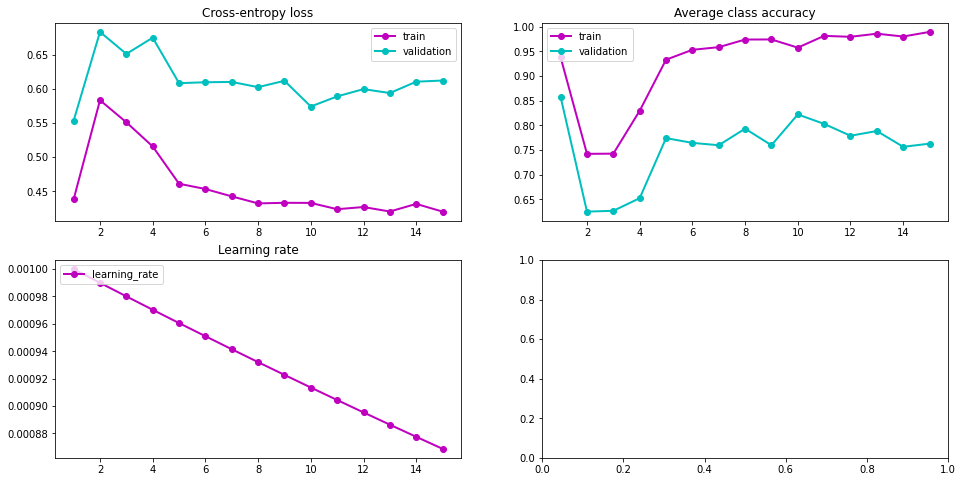

In [32]:
def trainNetwork():
    """Performs a standard procedure for training a neural network.
    Training progress after each learning epoch is evaluated in order to
    gain insigth into ConvNets continuous performance.
    Important notes
    ---------------
    Loss function: Cross entropy loss

    Optimizer: SGD
    
    Scheduler: MultiStepLR
    """
    plot_data = {}
    plot_data['train_loss'] = []
    plot_data['valid_loss'] = []
    plot_data['train_acc'] = []
    plot_data['valid_acc'] = []
    plot_data['lr'] = []
    SAVE_DIR = '/content/drive/MyDrive/ASUB'
    device = torch.device('cuda')

    model = resnet_type[18](pretrained=True)
    in_ftr  = model.fc.in_features
    model.fc = nn.Linear(in_ftr, 1)
    model.train()

    net = model.to(device=device)
    #summary(net, (3, 224, 224))

    lossFunc = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    schedulerExp = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    
    for e in range(epoch):
        print(f"Started epoch {e}")
    
        accLoss = 0.0

        for i, data in enumerate(trainLoader, 0):

            inputs, labels = data
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)

            optimizer.zero_grad()

            outputs = net.forward(inputs)
            loss = lossFunc(outputs, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()

            accLoss += loss.item()

            if i % 50 == 0:
                print("Epoch: %d, Iteration: %5d, Loss: %.3f" % ((e + 1), (i), (accLoss / (i + 1))))
                
        train_loss, train_acc = evaluate(net, False, os.path.join(SAVE_DIR, "train_eval"))
        val_loss, val_acc = evaluate(net, True, os.path.join(SAVE_DIR, "test_eval"))

        plot_data['train_loss'] += [train_loss]
        plot_data['valid_loss'] += [val_loss]
        plot_data['train_acc'] += [train_acc]
        plot_data['valid_acc'] += [val_acc]
        plot_data['lr'] += [schedulerExp.get_last_lr()]

        schedulerExp.step()
    
    val_loss, val_acc = evaluate(net, True, os.path.join(SAVE_DIR, "final_eval7"))
    plot_training_progress(SAVE_DIR, plot_data)
    PATH = os.path.join(SAVE_DIR, "pneumonia.pth")
    torch.save(net.state_dict(), PATH)

trainNetwork()